In [ ]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level disk.jl")
using .LLD

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(energies, ss_m; 
    title = nothing, ylims = (nothing, nothing),
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)",
)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "m",
        ylabel = ylabel
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(ss_m)
        x = ss_m[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        if isassigned(energies,i)
            for e in energies[i]
                scatter!(ax, x, e, color = :blue, marker=:hline)
            end
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
    fig
end

plot_ed_spectrum (generic function with 1 method)

In [14]:
# Define k-mesh mimicing the angular momentum
m_list = [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14;
          0 0 0 0 0 0 0 0 0 0  0  0  0  0  0]
Nm = 15

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [15]:
# Set up one-body Hamiltonian matrix for inter-layer tunneling
ΔE = 0.0 * LLD.W0                # Energy difference between the two layers

# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, No tunneling
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nm)
for m_idx in 1:Nm
    H_onebody_bilayer_no_tunneling[1, 1, 1, m_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, m_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = AngularLandauInteraction(
    # ReciprocalLattice(5//3, 1//10),  # use some random lattice to avoid CDW phase
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [17]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.2                   # Inter-layer distance d/l
# compute the pseudo-potential components
generate_Coulomb_interaction(sys_int, 2(Nm-1))
@show sys_int.V_intra_Coulomb
@show sys_int.V_inter_Coulomb

# use Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = m_list, 
    Gk = (0, 0), 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
);

sys_int.V_intra_Coulomb = [1.634691278690283, 0.7493383601164756, 0.5286420776719373, 0.4187109289395484, 0.35030875074472057, 0.30266490471845026, 0.2671251264726862, 0.23936242215567627, 0.21694297387769915, 0.19837954758714904, 0.18270552679386037, 0.16926192958445965, 0.15758204297210426, 0.14732486590665303, 0.13823469977565214, 0.13011555581165724, 0.12281436003304884, 0.11620959195166342, 0.11020339485028822, 0.10471596998406457, 0.09968151242772676, 0.09504521139098399, 0.09076100049735537, 0.08678984607672632, 0.08309842775884828, 0.07965810937009314, 0.07644412755441585, 0.07343494569835757, 0.0706117347887325]
sys_int.V_inter_Coulomb = [1.4511894967074435, 0.7417093243133075, 0.5264772245136036, 0.41763036741493487, 0.3496396906862018, 0.30220201813137615, 0.26678248436536856, 0.23909698282384967, 0.21673050598765223, 0.19820523802144346, 0.18255974688684778, 0.16913811591600048, 0.15747554859673946, 0.14723229723864525, 0.13815351381895055, 0.13004380499306584, 0.1227505247

In [18]:
# number of electrons in each layer
Ne1 = 3
Ne2 = 9
Ne = (Ne1, Ne2)

(3, 9)

In [19]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_m, _= ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces) |> maximum)

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatterList_onebody(para_conserve);
scat_list2_conserve = ED_sortedScatterList_twobody(para_conserve);

81247

In [20]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), angular momentum $(ss_m[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2_conserve, scat_list1_conserve;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 1, angular momentum 39


┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192


  0.141185 seconds (308.70 k allocations: 15.410 MiB, 7.27% gc time, 548.06% compilation time)
  0.000024 seconds (21 allocations: 1.281 KiB)
Processing subspace #2 with size 2, angular momentum 40
  0.001938 seconds (175 allocations: 27.855 KiB)
  0.000022 seconds (23 allocations: 2.578 KiB)
Processing subspace #3 with size 5, angular momentum 41
  0.001909 seconds (206 allocations: 80.174 KiB)
  0.000030 seconds (24 allocations: 6.069 KiB)
Processing subspace #4 with size 10, angular momentum 42
  0.001978 seconds (237 allocations: 114.875 KiB)
  0.000037 seconds (24 allocations: 13.679 KiB)
Processing subspace #5 with size 19, angular momentum 43
  0.002426 seconds (247 allocations: 185.017 KiB)
  0.000177 seconds (28 allocations: 33.300 KiB)
Processing subspace #6 with size 33, angular momentum 44
  0.000584 seconds (262 allocations: 360.361 KiB)
  0.000144 seconds (29 allocations: 78.744 KiB)
Processing subspace #7 with size 57, angular momentum 45
  0.003324 seconds (330 allocati

┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\Momentu

Processing subspace #10 with size 219, angular momentum 48
  0.001884 seconds (561 allocations: 2.647 MiB)
  0.032135 seconds (2.90 k allocations: 1.369 MiB)
Processing subspace #11 with size 326, angular momentum 49
  0.003288 seconds (748 allocations: 4.880 MiB)
  0.029836 seconds (3.65 k allocations: 2.425 MiB)
Processing subspace #12 with size 472, angular momentum 50
  0.009082 seconds (928 allocations: 5.833 MiB, 56.15% gc time)
  0.029583 seconds (3.97 k allocations: 3.576 MiB)
Processing subspace #13 with size 674, angular momentum 51
  0.006014 seconds (1.15 k allocations: 10.672 MiB)
  0.018691 seconds (4.32 k allocations: 5.308 MiB, 40.89% gc time)
Processing subspace #14 with size 937, angular momentum 52
  0.006518 seconds (1.45 k allocations: 12.588 MiB)
  0.031861 seconds (4.89 k allocations: 8.130 MiB, 8.25% gc time)
Processing subspace #15 with size 1286, angular momentum 53
  0.011427 seconds (1.84 k allocations: 21.223 MiB, 12.90% gc time)
  0.043120 seconds (4.96 k 

┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\Momentu

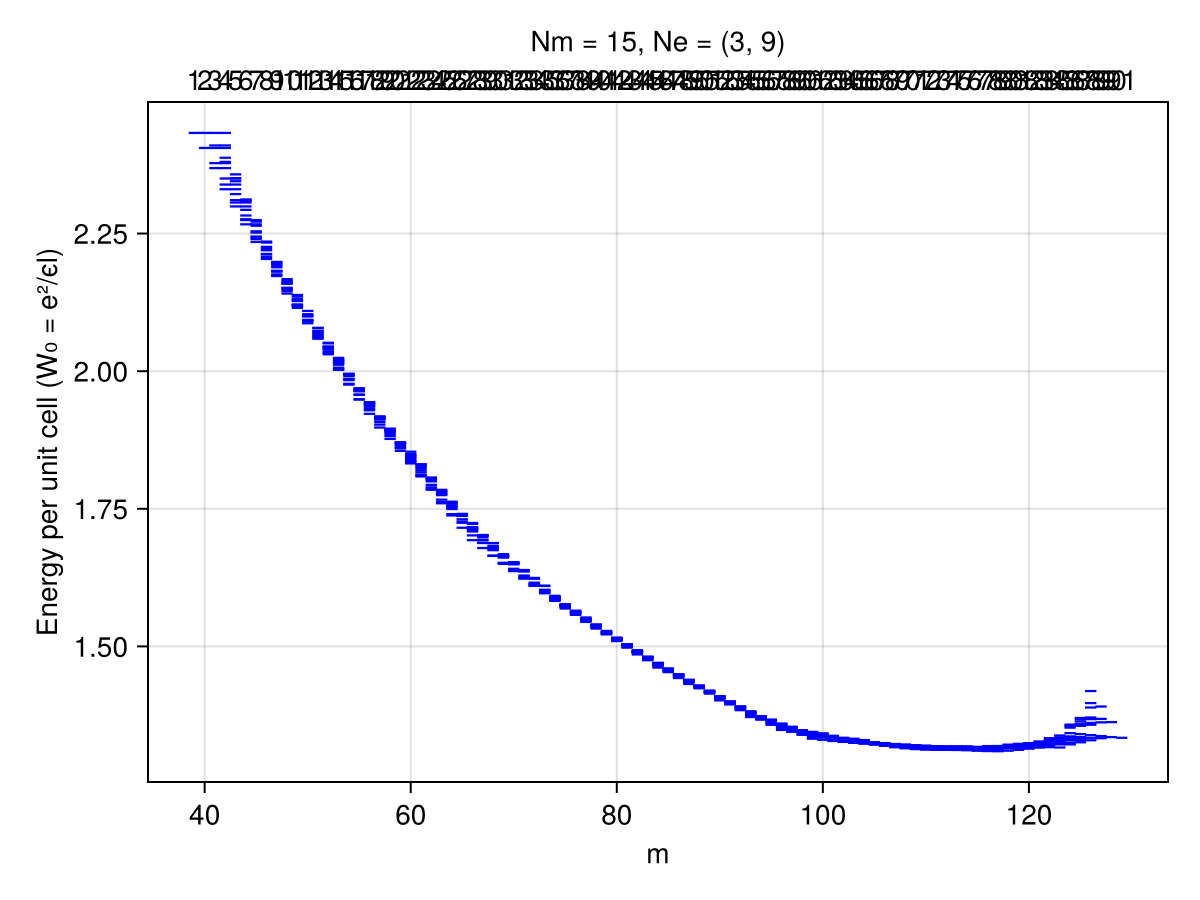

In [21]:
plot_ed_spectrum(energies/Nm/LLD.W0, ss_m,
    title = "Nm = $Nm, Ne = $Ne",
    # ylims = (0.372, 0.377),
);